In [1]:
# 1. Import Libraries and Set Device
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm
import os
import random

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Parameters
N_WAY = 20
K_SHOT = 5
N_QUERY = 5
OUTPUT_DIM = 128  # As requested
IMG_SIZE = 28

# 2. Download and Prepare Omniglot Dataset
# We need a custom dataset handler for Few-Shot Learning (N-way K-shot)

class OmniglotFewShot(Dataset):
    def __init__(self, root, background=True, transform=None):
        self.dataset = datasets.Omniglot(root, background=background, download=True, transform=transform)
        self.character_classes = []
        # Group images by character class
        self.data = {}
        for idx, (img, label) in enumerate(self.dataset):
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(img)
        self.classes = list(self.data.keys())
        
    def __len__(self):
        return len(self.classes)
    
    def get_task_batch(self, n_way, k_shot, n_query):
        # Sample N classes
        sampled_classes = random.sample(self.classes, n_way)
        
        support_set = []
        query_set = []
        support_labels = []
        query_labels = []
        
        for i, cls in enumerate(sampled_classes):
            imgs = self.data[cls]
            # Sample K_shot + N_query images
            sampled_imgs = random.sample(imgs, k_shot + n_query)
            
            # Support set
            for img in sampled_imgs[:k_shot]:
                support_set.append(img)
                support_labels.append(i)
                
            # Query set
            for img in sampled_imgs[k_shot:]:
                query_set.append(img)
                query_labels.append(i)
                
        support_set = torch.stack(support_set)
        query_set = torch.stack(query_set)
        support_labels = torch.tensor(support_labels)
        query_labels = torch.tensor(query_labels)
        
        return support_set, support_labels, query_set, query_labels

# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.92206,), (0.08426,))
])

print("Downloading/Loading Omniglot...")
train_dataset = OmniglotFewShot(root='./data', background=True, transform=transform)
test_dataset = OmniglotFewShot(root='./data', background=False, transform=transform)
print(f"Train classes: {len(train_dataset)}")
print(f"Test classes: {len(test_dataset)}")

# 3. Define MANN Model Architecture (128-dim Output)
# Copied and adapted from dimension/code.py

def quantize_to_int8(x, scale):
    # Placeholder for quantization function if needed inside model, 
    # but we will do post-training quantization for experiments.
    return x, scale

def dequantize_from_int8(x, scale):
    return x

class MANN(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        in_channels = 1 
        planes = [128, 128, 128, 128] 
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, planes[0], kernel_size=5, stride=2, padding=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(planes[0], planes[1], kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(planes[1], planes[2], kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(planes[2], planes[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )
        # Input size 28x28 -> 14x14 -> 14x14 -> 7x7 -> 7x7
        self.fc = nn.Linear(planes[3] * 7 * 7, out_dim) 
        
    def forward(self, x):
        features = self.model(x)
        features = features.view(features.size(0), -1)
        emb = self.fc(features)
        return emb

model = MANN(out_dim=OUTPUT_DIM).to(DEVICE)
print(model)

Using device: cuda
Downloading/Loading Omniglot...


100%|██████████| 9.46M/9.46M [00:00<00:00, 153MB/s]
100%|██████████| 6.46M/6.46M [00:00<00:00, 123MB/s]


Train classes: 964
Test classes: 659
MANN(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
  )
  (fc): Linear(in_features=6272, out_features=128, bias=True)
)


Starting Training...


  0%|          | 0/5000 [00:00<?, ?it/s]

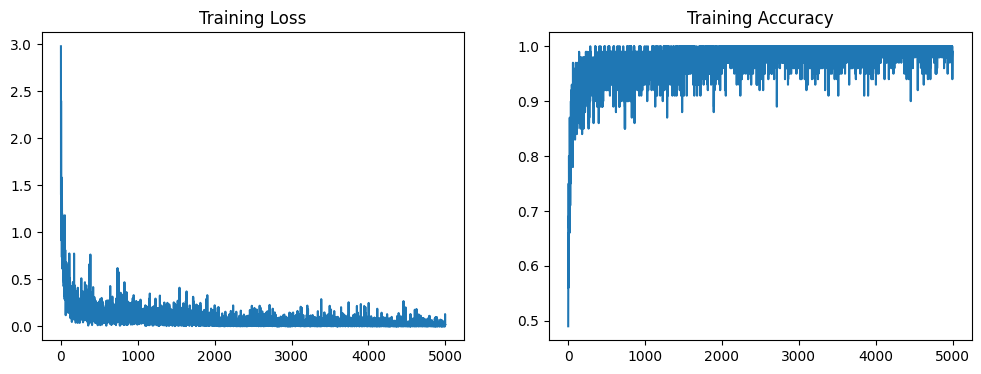

In [2]:
# 4. Training Loop (Prototypical Networks Approach)

def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def train_step(model, optimizer, dataset, n_way, k_shot, n_query):
    model.train()
    support_set, support_labels, query_set, query_labels = dataset.get_task_batch(n_way, k_shot, n_query)
    
    support_set = support_set.to(DEVICE)
    query_set = query_set.to(DEVICE)
    support_labels = support_labels.to(DEVICE)
    query_labels = query_labels.to(DEVICE)
    
    # Combine support and query to pass through model efficiently
    all_imgs = torch.cat([support_set, query_set], dim=0)
    all_emb = model(all_imgs)
    
    support_emb = all_emb[:len(support_set)]
    query_emb = all_emb[len(support_set):]
    
    # Compute Prototypes
    # support_emb: (N_way * K_shot, D)
    # Reshape to (N_way, K_shot, D) and take mean over K_shot
    prototypes = support_emb.view(n_way, k_shot, -1).mean(1)
    
    # Compute Distances
    dists = euclidean_dist(query_emb, prototypes)
    
    # Loss
    log_p_y = F.log_softmax(-dists, dim=1)
    loss = F.nll_loss(log_p_y, query_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Accuracy
    y_hat = log_p_y.argmax(1)
    acc = (y_hat == query_labels).float().mean().item()
    
    return loss.item(), acc

# Training Configuration
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

EPISODES = 5000  # Number of training episodes
PRINT_EVERY = 100

print("Starting Training...")
train_losses = []
train_accs = []

pbar = tqdm(range(EPISODES))
for episode in pbar:
    loss, acc = train_step(model, optimizer, train_dataset, N_WAY, K_SHOT, N_QUERY)
    train_losses.append(loss)
    train_accs.append(acc)
    scheduler.step()
    
    if (episode + 1) % PRINT_EVERY == 0:
        pbar.set_description(f"Ep {episode+1}: Loss {np.mean(train_losses[-PRINT_EVERY:]):.4f}, Acc {np.mean(train_accs[-PRINT_EVERY:]):.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title("Training Accuracy")
plt.show()

In [3]:
# 5. Dimensionality Reduction Methods

def quantize_int3(x):
    # 3-bit quantization (8 levels)
    # Range [-1, 1] mapped to integers [0, 7] or similar
    # Assuming input is somewhat normalized or we clip it.
    # Standard 3-bit signed integer range is [-4, 3] or unsigned [0, 7].
    # Let's use a simple uniform quantization to 8 levels.
    
    min_val = x.min()
    max_val = x.max()
    
    if max_val == min_val:
        return torch.zeros_like(x).int()
        
    # Normalize to [0, 1]
    x_norm = (x - min_val) / (max_val - min_val)
    
    # Scale to [0, 7] and round
    x_q = torch.round(x_norm * 7).int()
    
    return x_q

# Method 1: Direct INT3 (128 dim)
def method1_direct_int3(embeddings):
    return quantize_int3(embeddings)

# Method 2: Avg Pooling (128 -> 64) + INT3
def method2_avg_pooling_int3(embeddings):
    # Reshape to (N, 64, 2) and mean over last dim
    reshaped = embeddings.view(embeddings.size(0), 64, 2)
    pooled = reshaped.mean(dim=2)
    return quantize_int3(pooled)

# Method 3: PCA (128 -> 64) + INT3
# Requires fitting PCA first
def fit_pca(embeddings, n_components=64):
    pca = PCA(n_components=n_components)
    pca.fit(embeddings.cpu().numpy())
    return pca

def method3_pca_int3(embeddings, pca_model):
    reduced = pca_model.transform(embeddings.cpu().numpy())
    reduced = torch.tensor(reduced, device=embeddings.device)
    return quantize_int3(reduced)

# Method 4: Max Magnitude Pooling (128 -> 64) + INT3
def method4_max_mag_pooling_int3(embeddings):
    # Reshape to (N, 64, 2)
    reshaped = embeddings.view(embeddings.size(0), 64, 2)
    
    # Compare absolute values
    abs_vals = torch.abs(reshaped)
    # Get indices of max absolute values
    indices = torch.argmax(abs_vals, dim=2) # (N, 64)
    
    # Gather the original values using the indices
    # We need to gather from 'reshaped' using 'indices'
    # indices needs to be expanded to be used in gather
    indices_expanded = indices.unsqueeze(2)
    pooled = torch.gather(reshaped, 2, indices_expanded).squeeze(2)
    
    return quantize_int3(pooled)

# Method 5: AutoEncoder (128 -> 64) + INT3
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=128, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Linear(96, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 96),
            nn.ReLU(),
            nn.Linear(96, input_dim)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

def train_autoencoder(embeddings, epochs=500):
    ae = AutoEncoder().to(DEVICE)
    optimizer = optim.Adam(ae.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(embeddings)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    print("Training AutoEncoder...")
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            optimizer.zero_grad()
            recon, z = ae(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"AE Epoch {epoch+1}: Loss {total_loss/len(loader):.4f}")
            
    return ae

def method5_ae_int3(embeddings, ae_model):
    ae_model.eval()
    with torch.no_grad():
        _, z = ae_model(embeddings)
    return quantize_int3(z)

Preparing for experiments...
Extracting embeddings for PCA/AE training...
Training AutoEncoder...
AE Epoch 10: Loss 0.0075
AE Epoch 20: Loss 0.0041
AE Epoch 30: Loss 0.0030
AE Epoch 40: Loss 0.0024
AE Epoch 50: Loss 0.0021
AE Epoch 60: Loss 0.0018
AE Epoch 70: Loss 0.0016
AE Epoch 80: Loss 0.0015
AE Epoch 90: Loss 0.0014
AE Epoch 100: Loss 0.0013
AE Epoch 110: Loss 0.0012
AE Epoch 120: Loss 0.0012
AE Epoch 130: Loss 0.0011
AE Epoch 140: Loss 0.0011
AE Epoch 150: Loss 0.0011
AE Epoch 160: Loss 0.0010
AE Epoch 170: Loss 0.0009
AE Epoch 180: Loss 0.0009
AE Epoch 190: Loss 0.0009
AE Epoch 200: Loss 0.0008
AE Epoch 210: Loss 0.0008
AE Epoch 220: Loss 0.0008
AE Epoch 230: Loss 0.0008
AE Epoch 240: Loss 0.0009
AE Epoch 250: Loss 0.0007
AE Epoch 260: Loss 0.0008
AE Epoch 270: Loss 0.0007
AE Epoch 280: Loss 0.0008
AE Epoch 290: Loss 0.0007
AE Epoch 300: Loss 0.0007
AE Epoch 310: Loss 0.0007
AE Epoch 320: Loss 0.0007
AE Epoch 330: Loss 0.0006
AE Epoch 340: Loss 0.0007
AE Epoch 350: Loss 0.0006
A

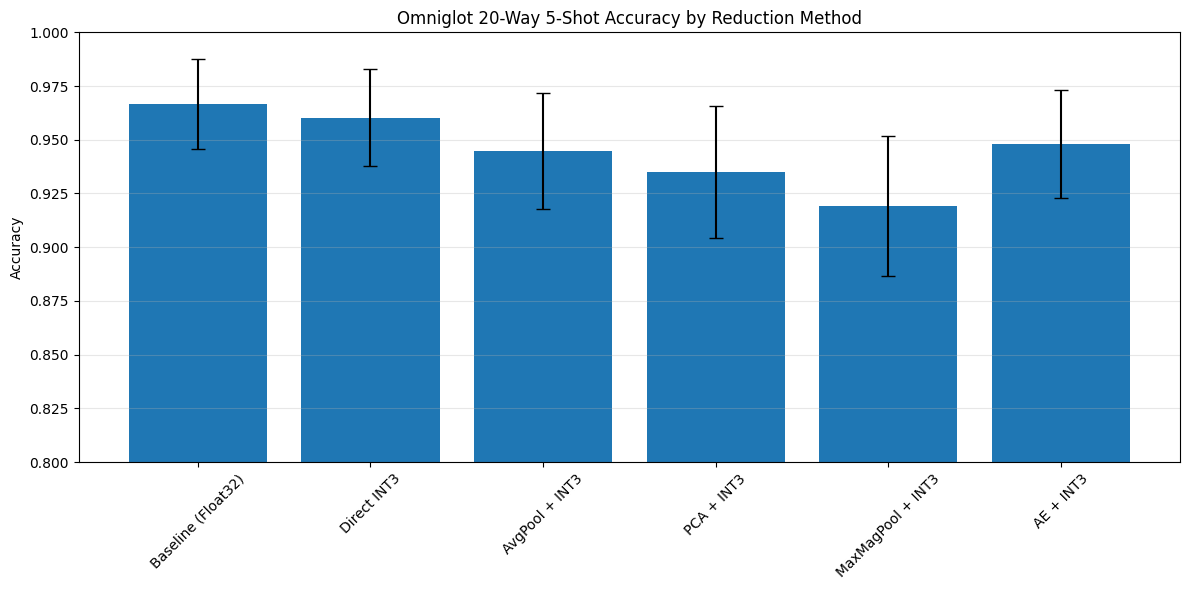


Summary Results:
Method                    | Accuracy   | Std Dev   
--------------------------------------------------
Baseline (Float32)        | 0.9666     | 0.0209
Direct INT3               | 0.9603     | 0.0226
AvgPool + INT3            | 0.9447     | 0.0270
PCA + INT3                | 0.9351     | 0.0307
MaxMagPool + INT3         | 0.9192     | 0.0326
AE + INT3                 | 0.9481     | 0.0250


In [ ]:
# 6. Evaluation and Experiments
import time

def get_all_embeddings(model, dataset):
    # Extract embeddings for a subset of data to train PCA/AE
    # Since Omniglot is small, we can try to get one sample per class or just random samples
    model.eval()
    embeddings = []
    
    # Just iterate through the dataset once (one image per sample if possible, or just random batches)
    # Let's sample 1000 images randomly
    loader = DataLoader(dataset.dataset, batch_size=64, shuffle=True)
    
    print("Extracting embeddings for PCA/AE training...")
    with torch.no_grad():
        count = 0
        for imgs, _ in loader:
            imgs = imgs.to(DEVICE)
            emb = model(imgs)
            embeddings.append(emb)
            count += len(imgs)
            if count >= 2000: # 2000 samples should be enough
                break
                
    return torch.cat(embeddings, dim=0)

def evaluate_method(model, dataset, reduction_fn, n_episodes=100):
    model.eval()
    accuracies = []
    total_time = 0
    
    for _ in range(n_episodes):
        support_set, support_labels, query_set, query_labels = dataset.get_task_batch(N_WAY, K_SHOT, N_QUERY)
        
        support_set = support_set.to(DEVICE)
        query_set = query_set.to(DEVICE)
        support_labels = support_labels.to(DEVICE)
        query_labels = query_labels.to(DEVICE)
        
        # Get original embeddings
        with torch.no_grad():
            all_imgs = torch.cat([support_set, query_set], dim=0)
            all_emb = model(all_imgs)
            
        # Apply Dimensionality Reduction
        # reduction_fn should take (N, D) and return (N, D_new)
        start_t = time.time()
        reduced_emb = reduction_fn(all_emb)
        end_t = time.time()
        total_time += (end_t - start_t)
        
        # Cast back to float for distance computation if it's int
        reduced_emb = reduced_emb.float()
        
        support_emb = reduced_emb[:len(support_set)]
        query_emb = reduced_emb[len(support_set):]
        
        # Prototypes
        prototypes = support_emb.view(N_WAY, K_SHOT, -1).mean(1)
        
        # Distances
        dists = euclidean_dist(query_emb, prototypes)
        
        # Accuracy
        y_hat = (-dists).argmax(1)
        acc = (y_hat == query_labels).float().mean().item()
        accuracies.append(acc)
        
    return np.mean(accuracies), np.std(accuracies), total_time / n_episodes

# Prepare for experiments
print("Preparing for experiments...")
# 1. Get data for fitting PCA/AE
train_embeddings = get_all_embeddings(model, train_dataset)

# 2. Fit PCA
pca_model = fit_pca(train_embeddings, n_components=64)

# 3. Train AutoEncoder
ae_model = train_autoencoder(train_embeddings, epochs=500)

# Run Experiments
results = {}
n_test_episodes = 500

print(f"\nRunning evaluation on {n_test_episodes} episodes per method...")

# Baseline (No reduction, float32)
print("Evaluating Baseline (Float32)...")
acc, std, avg_time = evaluate_method(model, test_dataset, lambda x: x, n_episodes=n_test_episodes)
results['Baseline (Float32)'] = (acc, std, avg_time)
print(f"Baseline: {acc:.4f} +/- {std:.4f}, Time: {avg_time:.6f}s")

# Method 1: Direct INT3
print("Evaluating Method 1: Direct INT3...")
acc, std, avg_time = evaluate_method(model, test_dataset, method1_direct_int3, n_episodes=n_test_episodes)
results['Direct INT3'] = (acc, std, avg_time)
print(f"Direct INT3: {acc:.4f} +/- {std:.4f}, Time: {avg_time:.6f}s")

# Method 2: AvgPool + INT3
print("Evaluating Method 2: AvgPool + INT3...")
acc, std, avg_time = evaluate_method(model, test_dataset, method2_avg_pooling_int3, n_episodes=n_test_episodes)
results['AvgPool + INT3'] = (acc, std, avg_time)
print(f"AvgPool + INT3: {acc:.4f} +/- {std:.4f}, Time: {avg_time:.6f}s")

# Method 3: PCA + INT3
print("Evaluating Method 3: PCA + INT3...")
acc, std, avg_time = evaluate_method(model, test_dataset, lambda x: method3_pca_int3(x, pca_model), n_episodes=n_test_episodes)
results['PCA + INT3'] = (acc, std, avg_time)
print(f"PCA + INT3: {acc:.4f} +/- {std:.4f}, Time: {avg_time:.6f}s")

# Method 4: MaxMagPool + INT3
print("Evaluating Method 4: MaxMagPool + INT3...")
acc, std, avg_time = evaluate_method(model, test_dataset, method4_max_mag_pooling_int3, n_episodes=n_test_episodes)
results['MaxMagPool + INT3'] = (acc, std, avg_time)
print(f"MaxMagPool + INT3: {acc:.4f} +/- {std:.4f}, Time: {avg_time:.6f}s")

# Method 5: AE + INT3
print("Evaluating Method 5: AE + INT3...")
acc, std, avg_time = evaluate_method(model, test_dataset, lambda x: method5_ae_int3(x, ae_model), n_episodes=n_test_episodes)
results['AE + INT3'] = (acc, std, avg_time)
print(f"AE + INT3: {acc:.4f} +/- {std:.4f}, Time: {avg_time:.6f}s")

# Plot Results
names = list(results.keys())
means = [results[n][0] for n in names]
stds = [results[n][1] for n in names]
times = [results[n][2] for n in names]

plt.figure(figsize=(12, 6))
plt.bar(names, means, yerr=stds, capsize=5)
plt.title(f"Omniglot {N_WAY}-Way {K_SHOT}-Shot Accuracy by Reduction Method")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Times
plt.figure(figsize=(12, 6))
plt.bar(names, times, color='orange')
plt.title(f"Average Reduction Time per Episode")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print Summary Table
print("\nSummary Results:")
print(f"{'Method':<25} | {'Accuracy':<10} | {'Std Dev':<10} | {'Time (s)':<10}")
print("-" * 65)
for name in names:
    print(f"{name:<25} | {results[name][0]:.4f}     | {results[name][1]:.4f}     | {results[name][2]:.6f}")

In [ ]:
# 7. Save Results to CSV
import pandas as pd

# Create a list of dictionaries for the DataFrame
data = []
for method, (acc, std, avg_time) in results.items():
    data.append({
        'Method': method,
        'Accuracy': acc,
        'Std Dev': std,
        'Time (s)': avg_time
    })

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_filename = 'omniglot_mann_reduction_results.csv'
df.to_csv(csv_filename, index=False)

print(f"Results successfully saved to {csv_filename}")
df.head()

Results successfully saved to omniglot_mann_reduction_results.csv


,Method,Accuracy,Std Dev
0,Baseline (Float32),0.96658,0.020893
1,Direct INT3,0.96026,0.022586
2,AvgPool + INT3,0.94474,0.026962
3,PCA + INT3,0.93506,0.030708
4,MaxMagPool + INT3,0.91918,0.032600
